In [2]:
import torch
from torch import optim
from ignite.engine import Engine
from ignite.handlers import Checkpoint

### Load data

In [3]:
%run datasets/__init__.py

In [4]:
dataset_name = 'covid-kaggle'
kwargs = {
    'max_samples': None,
    'batch_size': 30,
}

train_dataloader = prepare_data_classification(dataset_name, 'train', **kwargs)
val_dataloader = prepare_data_classification(dataset_name, 'val', **kwargs)
test_dataloader = prepare_data_classification(dataset_name, 'test', **kwargs)
train_dataloader.dataset.size()

Loading train dataset...
Loading val dataset...
Loading test dataset...


(2327, 3)

### Load model

In [7]:
DEVICE = torch.device('cuda', 1)
DEVICE

device(type='cuda', index=1)

In [8]:
%run models/classification/__init__.py
%run models/checkpoint.py

In [9]:
# TODO: move this function to utils, eventually
def load_classification_model(run_name, debug=True, device=DEVICE,
                              # TODO: actually save these params:
                              model_name='resnet', labels=[], multilabel=True,
                              ):
    model = init_empty_model(model_name, # TODO: 
                             labels,
                             multilabel=multilabel,
                            ).to(DEVICE)

    DUMMY_LR = 0.0001 # TODO: actually save the learning rate
    optimizer = optim.Adam(model.parameters(), lr=DUMMY_LR)

    compiled_model = CompiledModel(model, optimizer)

    filepath = get_latest_filepath(run_name, classification=True, debug=debug)
    checkpoint = torch.load(filepath, map_location=device)
    Checkpoint.load_objects(compiled_model.to_save_checkpoint(), checkpoint)

    return compiled_model

In [10]:
# run_name = '0703_154230_covid-kaggle_tfs-small_lr1e-06'
run_name = '0703_190401_covid-kaggle_densenet-121_lr1e-06_os'
debug_run = True

labels = train_dataloader.dataset.labels
multilabel = train_dataloader.dataset.multilabel

In [12]:
compiled_model = load_classification_model(run_name, debug=debug_run,
                                           model_name='densenet-121',
                                           labels=labels,
                                           multilabel=multilabel,
                                          )

In [13]:
compiled_model.model

Densenet121CNN(
  (base_cnn): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

### Run in test

In [22]:
import matplotlib.pyplot as plt

In [14]:
%run losses/__init__.py

In [15]:
%run metrics/classification/__init__.py

In [16]:
%run -n train_classification.py

In [26]:
%run utils/cm.py

In [37]:
def evaluate_model(model, dataloader, n_epochs=1, device=DEVICE):
    loss = get_loss_function('cross-entropy')

    labels = dataloader.dataset.labels
    multilabel = dataloader.dataset.multilabel
    
    engine = Engine(get_step_fn(compiled_model.model,
                                loss,
                                training=False,
                                multilabel=multilabel,
                                device=device,
                               ))
    attach_metrics_classification(engine, labels, multilabel=multilabel)
    attach_metric_cm(engine, labels, multilabel=multilabel)

    engine.run(dataloader, 1)
    
    return engine.state.metrics

In [38]:
train_metrics = evaluate_model(compiled_model.model, train_dataloader)
val_metrics = evaluate_model(compiled_model.model, val_dataloader)
test_metrics = evaluate_model(compiled_model.model, test_dataloader)

In [43]:
test_metrics

{'loss': 0.1639290153980255,
 'acc': 0.9446366782006921,
 'prec_covid': 0.9090909090909091,
 'prec_pneumonia': 0.983739837398374,
 'prec_normal': 0.9166666666666666,
 'recall_covid': 0.9523809523809523,
 'recall_pneumonia': 0.9029850746268657,
 'recall_normal': 0.9850746268656716,
 'spec_covid': 0.9925373134328358,
 'spec_pneumonia': 0.9870967741935484,
 'spec_normal': 0.9225806451612903,
 'cm': tensor([[ 20,   0,   1],
         [  2, 124,   8],
         [  0,   2, 132]])}

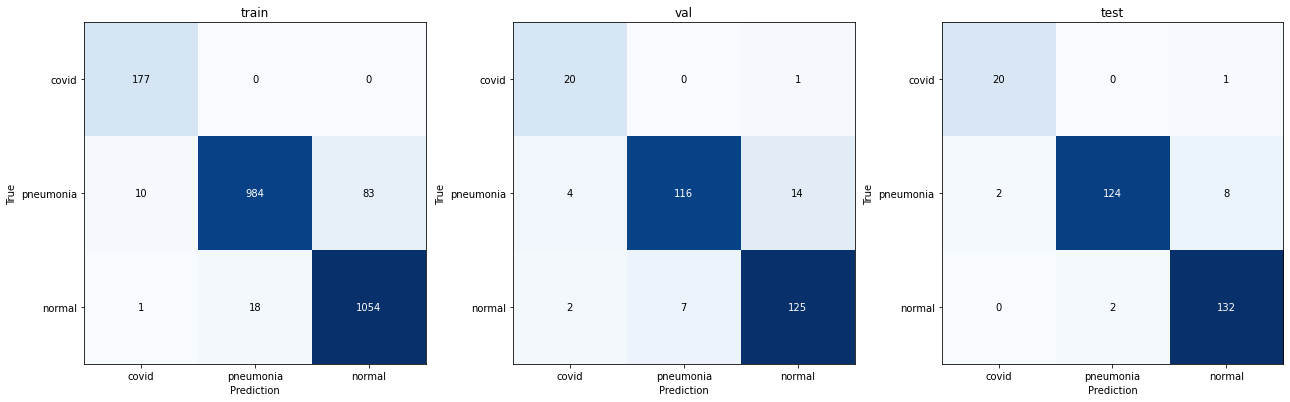

In [35]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plot_cm(train_metrics['cm'], labels, 'train')

plt.subplot(1, 3, 2)
plot_cm(val_metrics['cm'], labels, 'val')

plt.subplot(1, 3, 3)
plot_cm(test_metrics['cm'], labels, 'test')

plt.tight_layout(1)